### Feature Extraction with Decision Tree Classification

Labels come from 2 different PSG systems: Remlogic and Somnomedics. Sleep stage labels are as follows:

0 = Awake = SLEEP-S0 \
1 = REM = SLEEP-REM \
2 = Light = SLEEP-S1 and SLEEP-S2 \
3 = Deep = SLEEP-S3

EMFIT is the piezoelectric mat and Somnofy is the radar.

In [1]:
#! pip3 install tensorflow
#!pip3 install tsfresh

In [1]:
import os
from loader import *
from constants import *
from helpers import *
import pandas as pd
import numpy as np 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import select_features

In [3]:
x, y, x_big, y_big = get_nn_patients()
x.shape, y.shape, x_big.shape, y_big.shape

((50, 857, 2), (50, 857), (0,), (0,))

In [4]:
def get_df(plist):
    data = []
    for subjectId in plist:
        sleep_stages = read_patient_data(subjectId)
        augmented = augment_data(sleep_stages)
        augmented = augmented.reset_index()
        augmented.drop('index', axis=1, inplace=True)
        augmented = augmented.reset_index()
        augmented = augmented.rename(columns={'index': 'timestamp'})
        for row in range(augmented.shape[0]):
            data.append([row, augmented["sleep_stage_num_somnofy"][row],
                        augmented["sleep_stage_num_emfit"][row],
                        augmented["sleep_stage_num_psg"][row]])
    df = pd.DataFrame(data, columns=["id", 'radar', 'mat', "psg"])
    return df

In [5]:
excluded, included = PARTICIPANT_IDS[:5], PARTICIPANT_IDS[5:]
df = get_df(included)

In [6]:
df

,id,radar,mat,psg
0,0,0.0,0.0,0.0
1,1,0.0,0.0,0.0
2,2,0.0,0.0,0.0
3,3,0.0,0.0,0.0
4,4,0.0,0.0,0.0
...,...,...,...,...
38560,852,2.0,2.0,2.0
38561,853,2.0,2.0,2.0
38562,854,2.0,2.0,0.0
38563,855,2.0,2.0,2.0


### no grouping (DOESNT WORK w/ feature extraction)

In [28]:
""" 90% of magic lies
x = df[["radar", "mat"]].reset_index()
features = x.rename(columns={'index': 'id'})
y = df["psg"] 
"""
features = df[[ "radar", "mat"]]
y = df["psg"]

In [29]:
features.shape , y.shape

((38565, 2), (38565,))

### group by each timestamp mixing patient

In [79]:
df = df.sort_values('id')
y = []
for i in range(MEAN_SIZE):
    y.append(int(df[df["id"]==i]["psg"].mean()))
x = df[["id", "radar", "mat"]]
y = pd.Series(y)

In [80]:
x

,id,radar,mat
0,0,0.0,0.0
32566,0,3.0,1.0
29995,0,2.0,2.0
8570,0,2.0,2.0
30852,0,0.0,0.0
...,...,...,...
24852,856,0.0,0.0
33422,856,1.0,2.0
5141,856,0.0,0.0
28280,856,1.0,1.0


### group by a group of timestamp 
in groups of 9 sample ~4.5 min

In [7]:
n_sample = 9
x = df
for i in range(0, x.shape[0], n_sample):
    avg = round(x["psg"].iloc[i:i+n_sample].mean())
    x.loc[i:i+n_sample, "psg"] = avg
    x.loc[i:i+n_sample, "id"] = i / n_sample

In [8]:
y = x[["id", "psg"]]
y.drop_duplicates(inplace=True)
y = y.reset_index()
y = y["psg"]
x = x[["id", "radar", "mat"]]
x.shape, y.shape

/var/folders/7r/61bttw_50_7_mhx02bntv9qm0000gn/T/ipykernel_17567/1295387275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.drop_duplicates(inplace=True)


((38565, 3), (4285,))

## Feature Extraction and Decision Tree

In [9]:
features = extract_features(x, column_id="id")

Feature Extraction: 100%|███████████████████████| 30/30 [00:46<00:00,  1.55s/it]


In [10]:
features

,radar__variance_larger_than_standard_deviation,radar__has_duplicate_max,radar__has_duplicate_min,radar__has_duplicate,radar__sum_values,radar__abs_energy,radar__mean_abs_change,radar__mean_change,radar__mean_second_derivative_central,radar__median,...,mat__permutation_entropy__dimension_6__tau_1,mat__permutation_entropy__dimension_7__tau_1,mat__query_similarity_count__query_None__threshold_0.0,"mat__matrix_profile__feature_""min""__threshold_0.98","mat__matrix_profile__feature_""max""__threshold_0.98","mat__matrix_profile__feature_""mean""__threshold_0.98","mat__matrix_profile__feature_""median""__threshold_0.98","mat__matrix_profile__feature_""25""__threshold_0.98","mat__matrix_profile__feature_""75""__threshold_0.98",mat__mean_n_absolute_max__number_of_maxima_7
0,0.0,1.0,1.0,1.0,0.0,0.0,0.000,0.000,0.000000,0.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,0.0,1.0,1.0,1.0,7.0,7.0,0.125,0.125,0.000000,1.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
2,0.0,1.0,1.0,1.0,9.0,9.0,0.000,0.000,0.000000,1.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
3,0.0,1.0,1.0,1.0,13.0,21.0,0.125,0.125,0.000000,1.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.571429
4,0.0,1.0,1.0,1.0,18.0,36.0,0.000,0.000,0.000000,2.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4280,0.0,1.0,0.0,1.0,16.0,32.0,0.250,0.250,-0.142857,2.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
4281,0.0,1.0,1.0,1.0,18.0,36.0,0.000,0.000,0.000000,2.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
4282,0.0,1.0,1.0,1.0,18.0,36.0,0.000,0.000,0.000000,2.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
4283,0.0,1.0,1.0,1.0,18.0,36.0,0.000,0.000,0.000000,2.0,...,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.714286


In [11]:
impute(features)

filtered_features = select_features(features, y)
filtered_features

/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['radar__autocorrelation__lag_9' 'radar__partial_autocorrelation__lag_4'
 'radar__partial_autocorrelation__lag_5'
 'radar__partial_autocorrelation__lag_6'
 'radar__partial_autocorrelation__lag_7'
 'radar__partial_autocorrelation__lag_8'
 'radar__partial_autocorrelation__lag_9'
 'radar__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)'
 'radar__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)'
 'radar__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)'
 'radar__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)'
 'radar__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)'
 'radar__cwt_coefficients__coeff_10__w_5__widths_(2, 5, 10, 20)'
 'radar__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)'
 'radar__cwt_coefficients__coeff_10__w_20__widths_(2, 5, 10, 20)'
 'radar__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)'
 'r

,radar__sum_values,"radar__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)","radar__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)","radar__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)","radar__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)","radar__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)","radar__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)","radar__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)","radar__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)","radar__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)",...,"radar__fft_coefficient__attr_""abs""__coeff_1",radar__count_below_mean,"radar__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6","radar__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.6","radar__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6","radar__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.8",radar__longest_strike_below_mean,"radar__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8","radar__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.8",radar__mean_second_derivative_central
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,7.0,1.782079,2.028146,1.141360,1.523991,1.727377,0.948147,1.253816,1.362386,0.754207,...,1.879385,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.000000
2,9.0,2.233360,2.336893,1.519858,2.020684,2.235496,1.332403,1.782079,2.028146,1.141360,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,13.0,3.212904,3.311400,2.080852,2.730053,2.845012,1.702354,2.233360,2.336893,1.323856,...,2.879385,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.000000
4,18.0,4.466720,4.673786,3.039716,4.041369,4.470992,2.664806,3.564158,4.056292,2.282720,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4280,16.0,4.041369,4.470992,2.664806,3.564158,4.056292,2.282720,3.047983,3.454755,1.896293,...,2.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.142857
4281,18.0,4.466720,4.673786,3.039716,4.041369,4.470992,2.664806,3.564158,4.056292,2.282720,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4282,18.0,4.466720,4.673786,3.039716,4.041369,4.470992,2.664806,3.564158,4.056292,2.282720,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4283,18.0,4.466720,4.673786,3.039716,4.041369,4.470992,2.664806,3.564158,4.056292,2.282720,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [12]:
# train and test split
X_feature_train, X_feature_test, y_train, y_test = train_test_split(features, y, test_size=.33)
X_filtered_train, X_filtered_test = X_feature_train[filtered_features.columns], X_feature_test[filtered_features.columns]


In [13]:
X_feature_train.shape, X_feature_test.shape, y_train.shape, y_test.shape

((2870, 1578), (1415, 1578), (2870,), (1415,))

In [14]:
classifier_feature = DecisionTreeClassifier()
classifier_feature.fit(X_filtered_train, y_train) # CHANGE
preds = classifier_feature.predict(X_filtered_test)

In [15]:
print(classification_report(y_test,preds))
print(balanced_accuracy_score(y_test,preds))
print(accuracy_score(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.53      0.59      0.56       255
         1.0       0.57      0.52      0.54       340
         2.0       0.66      0.68      0.67       634
         3.0       0.63      0.56      0.59       186

    accuracy                           0.61      1415
   macro avg       0.60      0.59      0.59      1415
weighted avg       0.61      0.61      0.61      1415

0.5889270158047956
0.610600706713781


In [ ]:
df_te = get_df(excluded)
x_te = df_te[["radar", "mat"]].reset_index()
x_te = x_te.rename(columns={'index': 'id'})
y_te = df_te["psg"]
x_te.shape, y_te.shape

In [ ]:
df_te = get_df(excluded)
df_te = df_te.sort_values('id')
y_te = []
for i in range(MEAN_SIZE):
    y_te.append(round(df_te[df_te["id"]==i]["psg"].mean()))
x_te = df_te[["id", "radar", "mat"]]
y_te = pd.Series(y_te)
y_te = df_te["psg"]

In [ ]:
features = extract_features(x_te, column_id="id")
impute(features)
x_te_filtered = features[filtered_features.columns]


In [34]:
df_te = get_df(excluded)
x_te = df_te[["radar", "mat"]]
y_te = df_te["psg"]

In [35]:
preds = classifier_feature.predict(x_te)
print(classification_report(y_te,preds))
print(balanced_accuracy_score(y_te,preds))
print(accuracy_score(y_te,preds))

              precision    recall  f1-score   support

         0.0       0.80      0.55      0.65      1022
         1.0       0.41      0.56      0.48       612
         2.0       0.60      0.72      0.66      1829
         3.0       0.62      0.44      0.51       822

    accuracy                           0.60      4285
   macro avg       0.61      0.57      0.57      4285
weighted avg       0.63      0.60      0.60      4285

0.565535816281389
0.6009334889148191


<AxesSubplot:>

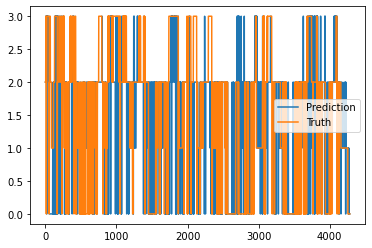

In [25]:
output = pd.DataFrame(preds, columns = ['Prediction'])
output["Truth"] = y_te
output.plot()

In [ ]:
from sklearn import tree
tree.plot_tree(classifier_feature, filled=True)


### Decision Tree

In [33]:
x, y, x_big, y_big = get_nn_patients(raw=True)
x.shape, y.shape, x_big.shape, y_big.shape

((50, 857, 9), (50, 857), (0,), (0,))

In [61]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33)
train, test = x_train.shape[0] * x_train.shape[1], x_test.shape[0] * x_test.shape[1]
x_train = x_train.reshape(train, x_train.shape[2])
x_test = x_test.reshape(test, x_test.shape[2])
y_train = y_train.reshape(train)
y_test = y_test.reshape(test)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((28281, 9), (14569, 9), (28281,), (14569,))

In [62]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Selecting the Best important features according to Logistic Regression
rfe_selector = RFE(estimator=LogisticRegression(),n_features_to_select=3, step = 1)
rfe_selector.fit(x_train, y_train)
print(rfe_selector.get_support())
# top 5: [0,2,4,5,8]
# top 3: [0,2,5]

/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

[ True False  True False False  True False False False]


In [63]:
x_featured, x_test = x_train[:,[0,2,5]], x_test[:,[0,2,5]]
x_featured.shape

(28281, 3)

In [64]:
classifier_feature = DecisionTreeClassifier()
classifier_feature.fit(x_featured, y_train) 
preds = classifier_feature.predict(x_test)

In [65]:
print(classification_report(y_test,preds))
print(balanced_accuracy_score(y_test,preds))
print(accuracy_score(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.66      0.55      0.60      3972
         1.0       0.50      0.40      0.45      2308
         2.0       0.60      0.73      0.66      6121
         3.0       0.64      0.58      0.61      2168

    accuracy                           0.60     14569
   macro avg       0.60      0.56      0.58     14569
weighted avg       0.61      0.60      0.60     14569

0.5637345267347151
0.604708627908573


### KMeans

In [73]:
x, y, x_big, y_big = get_nn_patients(raw=True)
x.shape, y.shape, x_big.shape, y_big.shape
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33)
train, test = x_train.shape[0] * x_train.shape[1], x_test.shape[0] * x_test.shape[1]
x_train = x_train.reshape(train, x_train.shape[2])
x_test = x_test.reshape(test, x_test.shape[2])
y_train = y_train.reshape(train)
y_test = y_test.reshape(test)
x_train.shape, x_test.shape, y_train.shape, y_test.shape
x_train, x_test = x_train[:,[0,2,5]], x_test[:,[0,2,5]]

In [74]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(x_train)

In [75]:
np.unique(y_km)

array([0, 1, 2, 3], dtype=int32)

In [76]:
print(classification_report(y_train,y_km))
print(balanced_accuracy_score(y_train,y_km))
print(accuracy_score(y_train,y_km))

              precision    recall  f1-score   support

         0.0       0.39      0.33      0.36      6151
         1.0       0.05      0.15      0.08      4440
         2.0       0.54      0.17      0.26     13568
         3.0       0.04      0.05      0.04      4122

    accuracy                           0.19     28281
   macro avg       0.26      0.18      0.19     28281
weighted avg       0.36      0.19      0.22     28281

0.1760098268435548
0.18591987553481135
